In [33]:
from yahoo_fin import stock_info as si
import pandas as pd
import numpy as np
from typing import List
import yfinance as yf
import re
from io import BytesIO, StringIO
import boto3

# 1. Ticker Symbols from pytickersymbols


python project: https://pypi.org/project/pytickersymbols/

In [ ]:
def create_constant_ticker_df():
    constant_tickers = [
        {"symbol": "ETH-USD", "name": "Ethereum USD", "country": None, "indices": None},
        {"symbol": "BTC-USD", "name": "Bitcoin USD", "country": None, "indices": None},
        {"symbol": "^GSPC", "name": "S&P 500 USD", "country": None, "indices": None},
        {"symbol": "FEZ", "name": "SPDR EURO STOXX 50 ETF USD", "country": None, "indices": None},
        {"symbol": "GC=F", "name": "Gold USD", "country": None, "indices": None},
        {"symbol": "SI=F", "name": "Silver USD", "country": None, "indices": None},
        {"symbol": "EURUSD=X", "name": "EUR USD", "country": None, "indices": None},
        {"symbol": "NOKUSD=X", "name": "Norwegian Crowns USD", "country": None, "indices": None},
        {"symbol": "SEKUSD=X", "name": "Scwedish Crowns USD", "country": None, "indices": None}
    ]

    dfp_constant_tickers = pd.DataFrame(constant_tickers)
    return dfp_constant_tickers

In [163]:
from pytickersymbols import PyTickerSymbols

stock_ticker_symbols = PyTickerSymbols()

smi_tickers = list(stock_ticker_symbols.get_stocks_by_index('SMI'))
dfp_tickers_smi = pd.DataFrame(smi_tickers)

sp100_tickers = list(stock_ticker_symbols.get_stocks_by_index('S&P 500'))
dfp_tickers_sp100 = pd.DataFrame(sp100_tickers)

nasdaq100_tickers = list(stock_ticker_symbols.get_stocks_by_index('NASDAQ 100'))
dfp_tickers_nasdaq100 = pd.DataFrame(nasdaq100_tickers)

dfp_tickers = pd.concat([dfp_tickers_smi,
                         dfp_tickers_sp100,
                         dfp_tickers_nasdaq100])
dfp_tickers = dfp_tickers[dfp_tickers["symbol"].isnull()==False]
dfp_tickers = dfp_tickers.drop_duplicates(["symbol"])
cols = [
    "symbol",
    "name",
    "country",
    "indices"
]
dfp_tickers=dfp_tickers[cols]

dfp_tickers["indices"] = dfp_tickers["indices"].apply(lambda x: ",".join(x))

In [166]:
dfp_tickers.shape

(520, 4)

In [167]:
dfp_tickers.head(5)

,symbol,name,country,indices
0,LIN,Linde PLC,United Kingdom,"DAX,EURO STOXX 50,S&P 100,S&P 500"
1,CCL,Carnival Corporation,United Kingdom,S&P 500
2,SSE,STERIS PLC,United Kingdom,S&P 500
3,MMM,3M Company,United States,"DOW JONES,S&P 100,S&P 500"
4,AXP,American Express Company,United States,"DOW JONES,S&P 100,S&P 500"


In [168]:
tickers = list(dfp_tickers["symbol"].unique())

In [169]:
len(tickers)

520

# 2. Stock Price Data from yfinance

In [181]:
def get_all_stocks_data(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    """
    Downloads price and volume data from yahoo finance for a list of ticker symbols for a time
    period specified by a start date and end date
    :param tickers: List[str], ticker symbols for which data is downloaded form yahoo finance
    :param start_date: str, format: %Y-%m-%d, the start date
    :param end_date: str, format: %Y-%m-%d, the end date
    :return:
    """
    n_tickers = len(tickers)
    iterations = 2
    step_size = int(n_tickers / iterations-1)

    df_list = []
    for k in range(0, iterations):
        print(k, "of", iterations)
        tickers_tmp = tickers[k:k + step_size]
        if len(tickers_tmp) > 0:
            sep = " "
            tickers_string = sep.join(tickers_tmp)
            df_tmp = yf.download(tickers_string, 
                                 start=start_date, 
                                 end=end_date, 
                                 group_by='ticker', 
                                 interval="1d")
            df_list.append(df_tmp)

    df_time_series = pd.concat(df_list)

    df_list = []
    for ticker in list(df_time_series.columns.levels[0]):
        df_tmp = df_time_series[ticker]
        df_tmp["symbol"] = ticker
        df_tmp = df_tmp[["symbol", "Close", "Volume"]]
        df_list.append(df_tmp)

    df_ts = pd.concat(df_list)
    df_ts = df_ts.reset_index()
    df_ts["Date"] = df_ts["Date"].astype(str)
    df_ts["year"] = df_ts["Date"].str.split("-", expand=True)[0].astype(int)
    df_ts["month"] = df_ts["Date"].str.split("-", expand=True)[1].astype(int)
    df_ts["day"] = df_ts["Date"].str.split("-", expand=True)[2].astype(int)
    df_ts = df_ts.drop(columns= ["Date"])
    df_ts = df_ts.dropna()

    renamed_columns = {
        "Close": "closing_price",
        "Volume": "volume"
    }

    df_ts = df_ts.rename(columns=renamed_columns)
    return df_ts

In [182]:
df_tmp = yf.download("MSFT", start="2021-01-01", 
                     end = "2021-03-01", group_by='ticker', interval="1d")

[*********************100%***********************]  1 of 1 completed


In [183]:
import time
start = time.time()
df2 = get_all_stocks_data(tickers= tickers, start_date="2020-01-01", end_date = "2020-04-01")
end = time.time()
print("time for downloading 3 months of stock data",end-start)

0 of 2
[*********************100%***********************]  259 of 259 completed

3 Failed downloads:
- COG: No data found, symbol may be delisted
- SSE: None
- RTN: No data found, symbol may be delisted
1 of 2
[*********************100%***********************]  259 of 259 completed

3 Failed downloads:
- COG: No data found, symbol may be delisted
- SSE: None
- RTN: No data found, symbol may be delisted


/Users/ralf/opt/anaconda3/envs/nb/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


time for downloading 3 months of stock data 81.17370510101318


In [184]:
df2.shape

(32256, 6)

In [185]:
df2.head(5)

,symbol,closing_price,volume,year,month,day
0,A,85.309998,1176200.0,2019,12,31
1,A,85.949997,1410500.0,2020,1,2
2,A,84.570000,1118300.0,2020,1,3
3,A,84.820000,1993200.0,2020,1,6
4,A,85.080002,1684700.0,2020,1,7


In [186]:
df2.dtypes

symbol            object
closing_price    float64
volume           float64
year               int64
month              int64
day                int64
dtype: object

# 3. Balance Sheet Data From Quandl

In [14]:
path_quandl = "/Users/ralf/Documents/6000_stocks/US_CORE_FINANCIAL_DATA_FULL_HISTORY/SHARADAR_SF1_017f04a0d2ef7cc409f920be72167ada.csv"

In [15]:
df_quandl = pd.read_csv(path_quandl)

cols = ['ticker',
        'dimension',
'reportperiod',
'liabilities',
'debt',
'equity',
'assets',
'marketcap',
'netinc',
'ebit',
'shareswa',
'shareswadil']

df_quandl = df_quandl[cols]
# convert from USD to billion USD
df_quandl["liabilities"] = df_quandl["liabilities"]/1e+09
df_quandl["debt"] = df_quandl["debt"]/1e+09
df_quandl["equity"] = df_quandl["equity"]/1e+09
df_quandl["assets"] = df_quandl["assets"]/1e+09
df_quandl["marketcap"] = df_quandl["marketcap"]/1e+09
df_quandl["netinc"] = df_quandl["netinc"]/1e+09
df_quandl["ebit"] = df_quandl["ebit"]/1e+09
df_quandl["shareswa"] = df_quandl["shareswa"]/1e+09
df_quandl["shareswadil"] = df_quandl["shareswadil"]/1e+09
# calculate additional indicators
df_quandl["earning_yield"] = df_quandl["netinc"]/df_quandl["marketcap"]
df_quandl["rota"] = df_quandl["netinc"]/df_quandl["assets"]
# Add columns for year, month and day
df_quandl["year"] = df_quandl["reportperiod"].str.split("-", expand=True)[0].astype(int)
df_quandl["month"] = df_quandl["reportperiod"].str.split("-", expand=True)[1].astype(int)
df_quandl["day"] = df_quandl["reportperiod"].str.split("-", expand=True)[2].astype(int)


In [16]:
df_quandl.shape

(2647073, 17)

In [17]:
df_quandl.dtypes

ticker            object
dimension         object
reportperiod      object
liabilities      float64
debt             float64
equity           float64
assets           float64
marketcap        float64
netinc           float64
ebit             float64
shareswa         float64
shareswadil      float64
earning_yield    float64
rota             float64
year               int64
month              int64
day                int64
dtype: object

In [19]:
df_quandl[df_quandl["ticker"] == "MSFT"].head(5)

,ticker,dimension,reportperiod,liabilities,debt,equity,assets,marketcap,netinc,ebit,shareswa,shareswadil,earning_yield,rota,year,month,day
1252751,MSFT,ARQ,1993-12-31,0.740,0.0,3.746,4.486,22.624783,0.289,0.438,9.728,9.728,0.012774,0.064423,1993,12,31
1252752,MSFT,ARQ,1994-03-31,0.914,0.0,4.012,4.926,26.923138,0.256,0.382,9.728,9.728,0.009509,0.051969,1994,3,31
1252753,MSFT,ARQ,1994-06-30,0.913,0.0,4.450,5.363,32.789541,0.362,0.540,9.856,9.856,0.011040,0.067500,1994,6,30
1252754,MSFT,ARQ,1994-09-30,1.207,0.0,4.430,5.637,37.563773,0.316,0.471,9.952,9.952,0.008412,0.056058,1994,9,30
1252755,MSFT,ARQ,1994-09-30,1.207,0.0,4.430,5.637,37.633659,0.316,0.471,9.952,9.952,0.008397,0.056058,1994,9,30


# 4. M2 Money Supply Data

Data source: https://stats.oecd.org/

In [20]:
path = "/Users/ralf/Documents/6000_stocks/MEI_FIN_20012022224609367.csv"
df_m3 = pd.read_csv(path)

df_m3["year"] = df_m3["TIME"].str.split("-",expand=True)[0]
df_m3["quarter"] = df_m3["TIME"].str.split("-",expand=True)[1]

def replace_none(x):
    if not x:
         return "full_year" 
    else:
        return x
    
df_m3["quarter"] = df_m3["quarter"].apply(replace_none)

cols = [
    "TIME",
    "Value",
    "Country",
    "Frequency"
]

#df_m3 = df_m3[cols]

renamed_columns = {
    "Value": "value",
    "Country": "country",
    "Frequency": "frequency",
    "Time": "time"
}


df_m3 = df_m3.rename(columns=renamed_columns)

In [21]:
df_m3.shape

(1422, 19)

In [23]:
df_m3[["value","country","frequency","time"]].head(5)

,value,country,frequency,time
0,12.78966,United States,Annual,1980
1,13.94482,United States,Annual,1981
2,15.20398,United States,Annual,1982
3,17.06026,United States,Annual,1983
4,18.42620,United States,Annual,1984


In [27]:
df_m3["country"].unique()

array(['United States', 'Euro area (19 countries)'], dtype=object)

Text(0.5, 0, 'Time (years)')

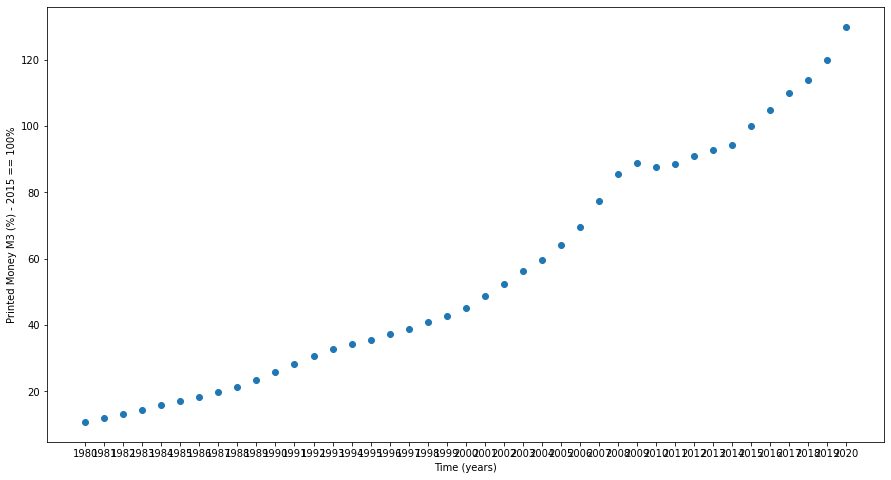

In [31]:
df_tmp = df_m3[df_m3["country"] == 'Euro area (19 countries)']
df_tmp = df_tmp[df_tmp["frequency"] == "Annual"]

import matplotlib.pyplot as plt

plt.figure(figsize = (15,8))
plt.scatter(df_tmp["time"],df_tmp["value"])
plt.ylabel("Printed Money M3 (%) - 2015 == 100%")
plt.xlabel("Time (years)")

In [34]:
np.max(df_m3["time"].values)

'Sep-2021'